# Сборный проект: 2

В данном проекте нам предстоит решить 2 задачи: одна линейной регрессии, другая классификации. В первой задаче нам предстоит предсказать уровень удовлетворенности сотрудников, а во второй предсказать возможное увольнение сотрудника, учитывая результаты его ответа на тест о условиях работы. <br/><br/>
**Суть исследования:** на основе имеющихся датафреймов подобрать лучшие модели для решения обоих задач.<br/><br/>
**Задачи исследования:** изучить и обработать входные данные, подготовить их для работы с моделями машинного обучения, подобрать лучшую и самую подходящую под нашу задачу модель. А так же составить портрет потенциального уволившегося сотрудника.<br/><br/>
**Исходные данные:** на входе имеем 3 датафрейма с данными о сотрудниках:
* датафрейм с данными о входных признаках - train_job_satisfaction_rate
* датафрейм с данными о входных признаках тестовой выборки - test_features
* датафрейм с целевым признаком тестовой выборки - test_target_job_satisfaction_rate
* датафрейм с данными о целевом признаке для 2 задачи - test_target_quit.csv
* датафрейм с данными о входные для 2 задачи - train_quit.csv

**Данное исследование будет идти по такому плану:**<br/>
* обзор данных
* предобработка данных
* исследовательский анализ данных
* подготовка данных для работы с моделью
* работа с пайплайном
* анализ метрик лучшей модели
* усовершенствование моделей
* общие выводы из задач и по всему исследованию

In [8]:
#пипы
!pip install scikit-learn -q
!pip install phik -q
!pip install --upgrade matplotlib -q
!pip install --upgrade seaborn -q

In [9]:
#импорты
import pandas as pd
import warnings
warnings.simplefilter("ignore") 
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

import phik
from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder

## Задача: предсказание уровня удовлетворённости сотрудника

Задание: построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика

### Шаг.  Загрузка данных

In [3]:
#создадим 3 датасета и загрузим в них исходные датафремы
X_train_full = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep=',')
X_test = pd.read_csv('/datasets/test_features.csv', sep=',')
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',')


#выведем несколько строк и проверим какие данные в них содержатся, а также выведем информацию о датафрейме
display(X_train_full.head(6))
print(X_train_full.info())
print()
display(X_test.head(6))
print(X_test.info())
print()
display(y_test.head(6))
print(y_test.info())
print()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None



,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None



Мы вывели по несколько строчек из каждого датафрейма, просмотрели и изучили общую информацию по каждому из них. Исходя из этого можно сделать следующие выводы: 
* датафремы содержат данные, которые и должны в них содержаться. Содержание соответствуют названию
* имеются пропуски значений, в тренировочном и тестовом датафрейме есть несколько пропусков в столбцах debt и level
* типы данных соответствуют действительным 
<br/>

Также в дальнейшем сделаем проверку на дубликаты и заполним пропуски.

### Шаг. Предобработка данных
В целом данные в порядке, нам не нужно переиминовывать называния столбцов, менять типы данных. Устранением пропусков мы займемся чуть дальше в пайплайне, а сейчас поищем дубликаты.

In [4]:
#отсортируем значения в датафреймах по возрастанию в колонке id, чтобы в дальнейшем не возникало путаницы.
X_train_full = X_train_full.sort_values(by = 'id')
X_test = X_test.sort_values(by = 'id')
y_test = y_test.sort_values(by = 'id')

Так же хочу перевести столбец с оценками в категориальный признак, где оценки 1-3 будут считаться низкими, а 4 и 5 - высокими.

In [5]:
# Определяем интервалы для категорий
df_new = pd.DataFrame(columns=['evaluation_category','supervisor_evaluation'])
bins = [0, 4, 6]  # 0-3 для низкой, 4-5 для высокой

# Определяем метки для категорий
labels = ['низкая', 'высокая']

# Создаем новый столбец с категориальным признаком
df_new['evaluation_category'] = pd.cut(X_train_full['supervisor_evaluation'], bins=bins, labels=labels, right=False)
X_train_full['supervisor_evaluation'] = df_new['evaluation_category']

In [6]:
df_new['evaluation_category'] = pd.cut(X_test['supervisor_evaluation'], bins=bins, labels=labels, right=False)
X_test['supervisor_evaluation'] = df_new['evaluation_category']

In [7]:
# Переводим столбцы типа category в тип object
X_test['supervisor_evaluation'] = X_test['supervisor_evaluation'].astype('object')
X_train_full['supervisor_evaluation'] = X_train_full['supervisor_evaluation'].astype('object')

In [8]:
print(X_train_full.duplicated().sum())
print(X_test.duplicated().sum())
print(y_test.duplicated().sum())

0
0
0


In [9]:
X_train_full.select_dtypes(include=['float64','int64']).columns.tolist()

['id', 'employment_years', 'salary', 'job_satisfaction_rate']

Явных дубликатов в данных найдено не было, а неявные по другим столбцам искать нет смысла, так как данные довольно обезличены и неявный дубликат может быть не ошибкой в данных, а вполне вероятным событием. <br/>
Проверим текстовые столбцы на уникальные значения и опечатки в них

In [10]:
#дадим имена нашим датафреймам чтобы использовать их как определитель, с каким из файлом мы сейчас работаем
X_train_full.__name__ = 'X_train_full'
X_test.__name__ = 'X_test'
y_test.__name__ = 'y_test'

df_list = [X_train_full, X_test, y_test]
#переберем все наши датафреймы в цикле

for df in df_list:
# Выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
# Цикл for для вывода списков уникальных значений по каждому категориальному столбцу
    print(f"Информация по датафрейму '{df.__name__}':\n")
    for column in categorical_columns:
        unique_values = df[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")
    print()

Информация по датафрейму 'X_train_full':

Уникальные значения для столбца 'dept': ['purchasing' 'sales' 'technology' 'hr' 'marketing' nan]
Уникальные значения для столбца 'level': ['junior' 'middle' 'sinior' nan]
Уникальные значения для столбца 'workload': ['low' 'medium' 'high']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['высокая' 'низкая']

Информация по датафрейму 'X_test':

Уникальные значения для столбца 'dept': ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']
Уникальные значения для столбца 'level': ['junior' 'middle' 'sinior' nan]
Уникальные значения для столбца 'workload': ['low' 'high' 'medium' ' ']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['высокая' 'низкая']

Информация п

Опечаток в данных замечено не было, так что можно спокойной начинать анализ данных. <br/>
Было замечено странное значение в столбцах workload и dept тестовой выборки. Выведем его, заменим на nan, а сам пропуск обработаем далее в пайплайне.

In [11]:
#заменим эти странные значения на nan чтобы в дальнейшем просто обработать это значение как пустое
X_test[X_test['workload'] == ' ']['workload'] = np.nan
X_test[X_test['dept'] == ' ']['dept'] = np.nan

### Шаг. Исследовательский анализ данных

Для исследовательского анализа данных выведем гистограммы для всех численных признаков и круговые диаграммы для категориальных

In [12]:
X_train_full.select_dtypes(include=['float64','int64']).columns.tolist()

['id', 'employment_years', 'salary', 'job_satisfaction_rate']

['id', 'employment_years', 'salary', 'job_satisfaction_rate']
['id', 'employment_years', 'salary']
['id', 'job_satisfaction_rate']


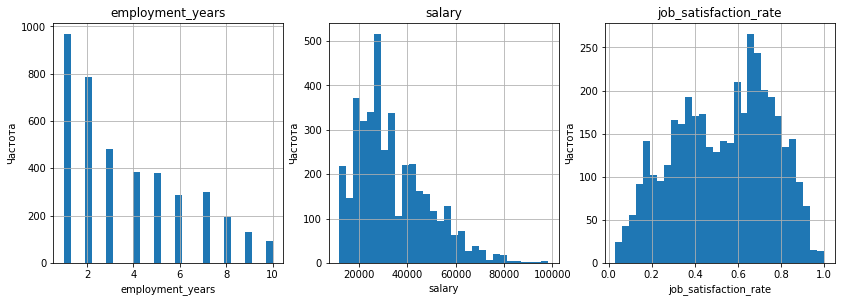

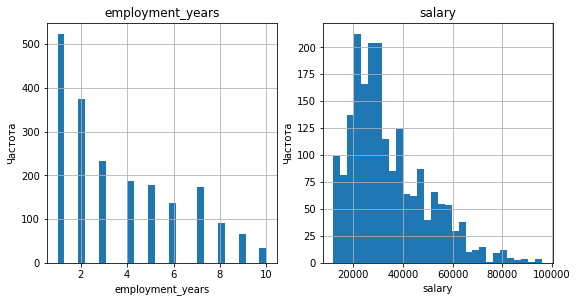

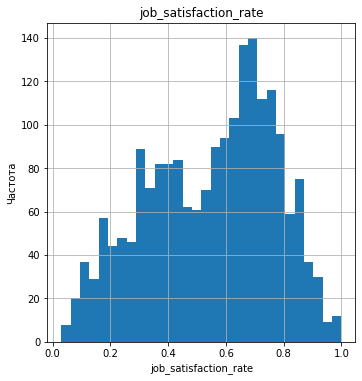

In [13]:
#начнем с количественных переменных
# выведем графики для каждого датафрема и для его численных столбцов
df_list = [X_train_full, X_test, y_test]
for df in df_list:
# Выберем все столбцы, которые имеют тип данных 'float','int' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    print(num_columns)
    
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(14, 15))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(3, 3, i + 1)  # 3 строки, 3 столбца, текущий график
    
    # Строим гистограмму для текущего столбца
        df[column].hist(bins=30)
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Частота')
        
plt.tight_layout()
plt.show()

Теперь все наглядно видно. Можно сделать выводы о распределении значений, исходя из графиков. Большинство из них распределены распределением Пуассона. <br/>
О сравнении тренировочной и тестовой выборке можно сказать что графики очень схожи. <br/>
Выведем теперь боксплоты для всех тех же признаков, и так же рассмотрим данные на выбросы


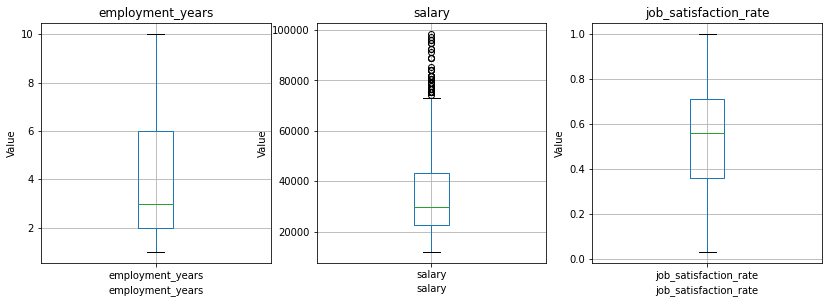

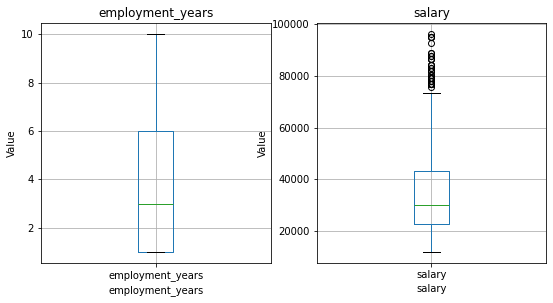

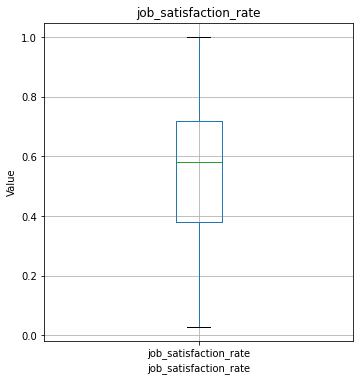

In [14]:
df_list = [X_train_full, X_test, y_test]
for df in df_list:
# Выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(14, 15))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(3, 3, i + 1)  # 2 строки, 3 столбца, текущий график
    
    # Строим график размаха для текущего столбца
        df.boxplot(column=column, ax=plt.gca())
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Value')
        
plt.tight_layout()
plt.show()


Явных выборосов не видно, только в колонках с оценкой качества работы сотрудника и размера зарплаты. Но мне кажется что такие выбросы удалять не следует, так как они встречаются в обоих выборках, имеют схожий вид и вполне себе имеют место быть в реальной жизни.

Круговые диаграммы для всех категориальных переменных:



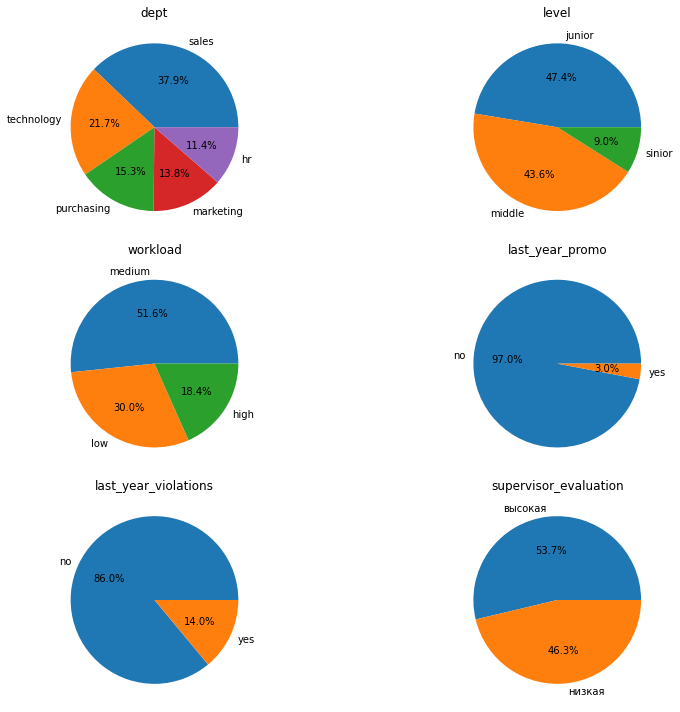

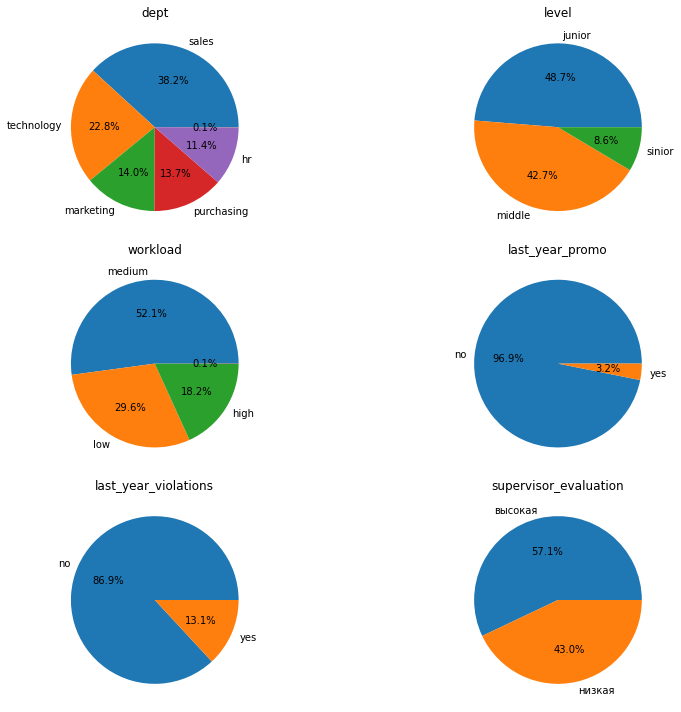

<Figure size 1008x720 with 0 Axes>

In [15]:
print('Круговые диаграммы для всех категориальных переменных:\n')

# Цикл для итерации по каждому датафрейму в списке
for df in df_list:
    plt.figure(figsize=(14, 10))
    
    # Получаем список категориальных столбцов для текущего датафрейма
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

    # Цикл для итерации по каждому категориальному столбцу
    for i, column in enumerate(categorical_columns):
        # Создаем subplot для текущего столбца
        plt.subplot(3, 2, i + 1)  # 3 строки, 2 столбца, текущий график
    
        # Подсчитываем количество каждого уникального значения в текущем столбце
        data = df[column].value_counts()
    
        # Строим круговую диаграмму для текущего столбца
        plt.pie(data, labels=data.index, autopct='%1.1f%%')
    
        # Добавляем заголовок с названием столбца
        plt.title(column)

    # Отображаем все круговые диаграммы для текущего датафрейма
    plt.tight_layout()
    plt.show()

В данном случае диаграмм получилось больше, чем в численных признаках, и нам нужно внимательно их изучить. Выводы:
* тренировочная и тестовая выборка одинаковы по процентному соотношению между собой категориальных признаков.
* большинство работников (38%) работают в отделе продаж и почти 23% - в отделе технологий
* почти 50% - Junior специалисты, а 42% - Middle. Оставшиеся 8.5% - Senior
* чуть больше половины сотрудников загружены средне
* повышение в прошлом году было только у 3% рабочих
* нарушение трудового договора наблюдалось у 13%

У нас наблюдается сильный дисбаланс классов, если говорить о таких признаках как Повышение в прошлом году и Нарушение трудового договора в прошлом году. Надо будет учесть это при подговке данных и использовать один из методов устранения дисбаланса классов.

Так же для наглядности зависимостей признаков друг с другом выведем матрицу корреляции 

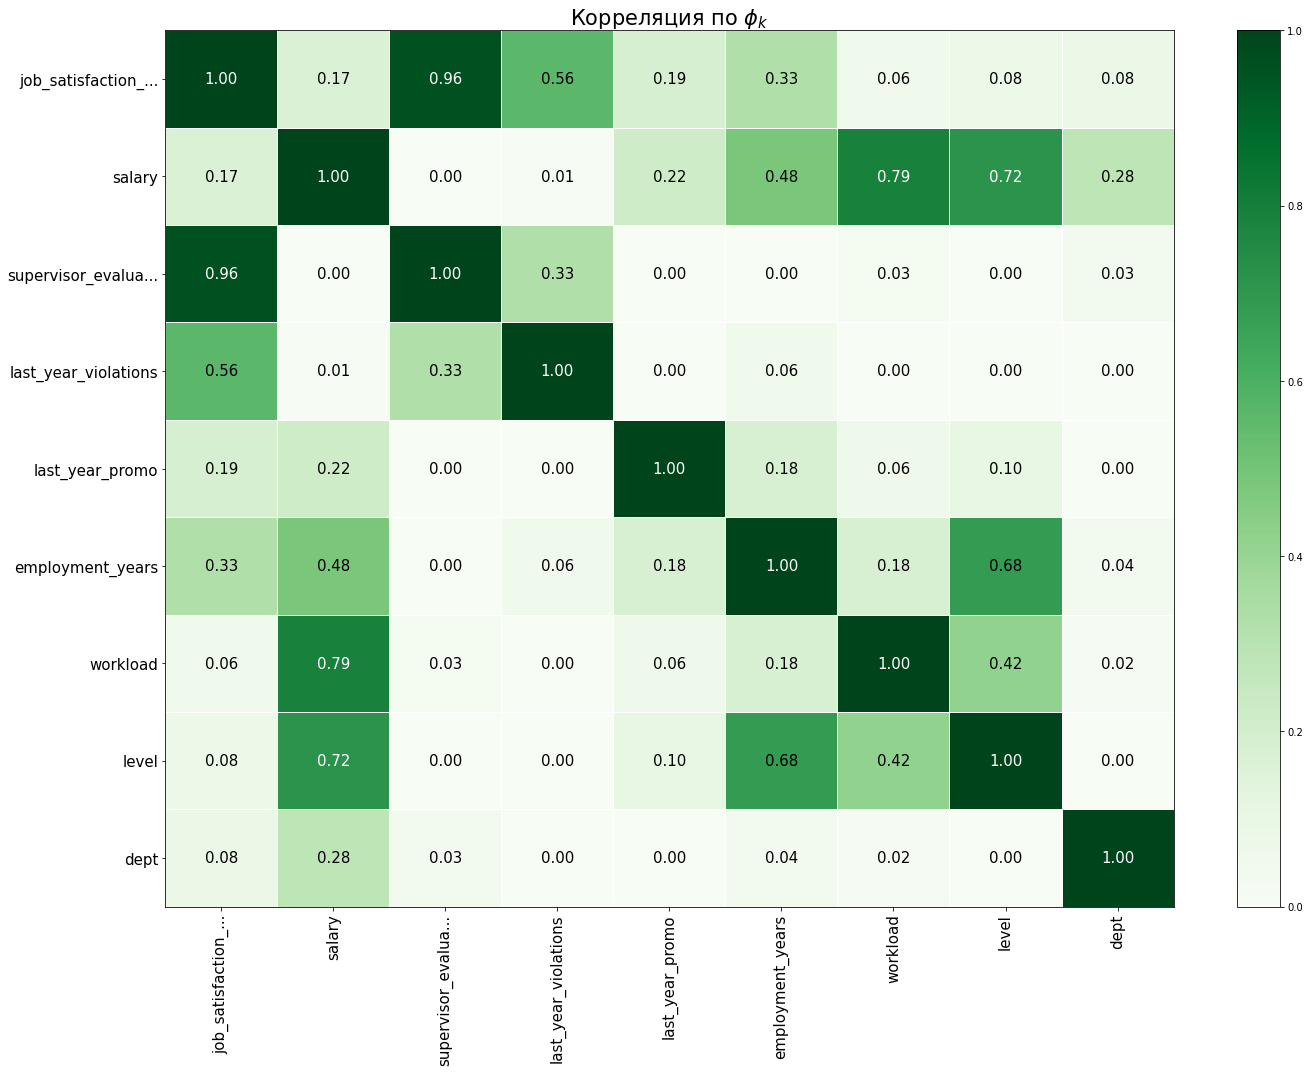

In [16]:
df_corr = X_train_full.drop(columns=['id'])
#соберем все численные переменные в датафрейме с помощью функции и сохраним их в переменную
num_columns = df_corr.select_dtypes(include=['float64','int64']).columns.tolist()

phik_matrix = df_corr.phik_matrix(interval_cols=num_columns)

#строим матрицу корреляции Phik
plot_correlation_matrix(phik_matrix.values, 
                       x_labels = phik_matrix.columns,
                       y_labels = phik_matrix.index,
                       vmin = 0, vmax = 1,color_map = 'Greens',
                       title = r'Корреляция по $\phi_k$',
                       fontsize_factor = 1.5, 
                       figsize = (20,15)
                       )

Мы получили матрицу корреляции. Можео заметить сильную корреляцию между оценкой работы сотрудника начальством и целевым признаком. А так, мультиколлинеарности между входными векторами замечено не было, значит можно продолжать.

### Шаг. Подготовка данных
Для начала я хочу разделить тренировочную выборку на X_train и y_train

In [17]:
#введем сразу константы и разделим наш датафрейм на тестовую и тренировочную выборки
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train = X_train_full.drop(
        [
            'job_satisfaction_rate'
        ], 
        axis=1
    )
y_train = X_train_full['job_satisfaction_rate']

In [18]:
# создадим списки для каждого кодирования

#для удобства выведем списки всех численных переменных, созданные ранее с помощью функции
num_columns = X_train_full.select_dtypes(include=['float64','int64']).columns.tolist()
num_columns

['id', 'employment_years', 'salary', 'job_satisfaction_rate']

In [19]:
# и так же варианты значения категориальных
cat_columns = X_train_full.select_dtypes(include=['object']).columns.tolist()
for column in cat_columns:
        unique_values = X_train_full[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")

Уникальные значения для столбца 'dept': ['purchasing' 'sales' 'technology' 'hr' 'marketing' nan]
Уникальные значения для столбца 'level': ['junior' 'middle' 'sinior' nan]
Уникальные значения для столбца 'workload': ['low' 'medium' 'high']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['высокая' 'низкая']


In [20]:
# признаки для OneHotEncoder
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

# признаки для OrdinalEncoder
ord_columns = ['level','workload', 'supervisor_evaluation']

# численные признаки
num_columns = ['employment_years',
 'salary']

In [7]:
# cоздаём пайплайн для подготовки признаков из списка ohe_columns:
ohe_pipe = Pipeline([
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (    'ohe', 
            OneHotEncoder(sparse=False, handle_unknown='ignore',drop='first')
        )
])

In [22]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns:
ord_pipe = Pipeline([
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior','middle','sinior'],
                    ['low','medium','high'],
                    ['низкая', 'высокая']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
       (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
])

In [23]:
# создайте общий пайплайн для объединения шагов подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)   
    ], 
    remainder =  'passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  Ord

In [24]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

Создадим словарь для каждой модели, в котором укажем гиперпараметры для дальнейшего перебора

In [25]:
param_grid = [
    {
    # словарь для модели DecisionTreeRegressor()
    'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': range(1,6),
    'models__min_samples_split': range(2,8),
    'models__min_samples_leaf': range(2, 8),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
     }
]

### Шаг. Обучение моделей

Для оценки качества работы модели создадим свою метрику, которая назвается SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение». Так же в дальшейшем для поиска лучшей модели будем использовать метод перебора всех значений по сетке GridSearchCV, так как он как раз работает с метриками для линейной регрессии.

In [26]:
def custom_metric(y_true, y_pred):
    # Рассчитываем значение метрики
    numerator = 100 / len(y_true) * np.sum(np.abs(y_true - y_pred))
    denominator = np.abs(y_true) + np.abs(y_pred)
    denominator[denominator == 0] = np.nan  # Исключаем деление на 0
    denominator = np.nanmean(denominator) / 2
    score = numerator / denominator
    return score

# Создаем scorer
SMAPE = make_scorer(custom_metric, greater_is_better=False)

In [27]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=SMAPE,
    n_jobs=-1
)

In [28]:
#обучим модель на тренировочной выборке
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
                          'models__max_depth': range(1, 6),
                          'models__min_samples_leaf': range(2, 8),
                          'models__min_samples_split': range(2, 8),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(custom_metric, greater_is_better=False, response_method='predict'))

In [29]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [30]:
X_test = X_test.sort_values(by = 'id')
y_test = y_test.sort_values(by = 'id')

In [31]:
X_test

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,высокая,19200
852,100480,marketing,junior,low,4,no,no,высокая,16800
848,100503,purchasing,middle,high,5,no,no,высокая,55200
524,100610,sales,middle,medium,5,no,no,высокая,43200
476,100692,sales,middle,high,6,no,no,высокая,48000
...,...,...,...,...,...,...,...,...,...
1925,997290,sales,sinior,medium,7,no,no,высокая,58800
1886,998548,marketing,junior,medium,2,no,no,высокая,32400
506,998762,technology,junior,low,3,no,no,низкая,22800
1579,998900,marketing,middle,medium,7,no,no,низкая,45600


In [32]:
y_test_SM = pd.Series(y_test['job_satisfaction_rate'])

In [33]:
# Рассчитайте значение метрики SMAPE
score = SMAPE(grid_search, X_test, y_test_SM)
print(f'Метрика SMAPE на тестовой выборке: {score}')

Метрика SMAPE на тестовой выборке: -13.96122784276829


Мы получили значени SMAPE, которое по модулю меньше 15! Следовательно наша модель работает как надо) <br/>
На тренировочной выборке значение получилось 14, а на тестовой 13.9


### Вывод по 1 задаче:

Мы добились желаемого показателя метрики, и достигли этого при помощи лучшей из подобранных моделей - LinearRegression(). Перебор был между деревом регрессии и линейной регрессии, и она справилась лучше. Видимо у входных данных была достаточная линейная зависимость с целевым признаком, из-за чего метрика получилась выше для этой модели. А так, линейная регрессия как раз и создана для решения задач предсказания числового параметра.

## Задача: предсказание увольнения сотрудника из компании

Задание: построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Шаг.  Загрузка данных

In [34]:
#создадим 3 датасета и загрузим в них исходные датафремы
X_train_full2 = pd.read_csv('/datasets/train_quit.csv', sep=',')
X_test2 = pd.read_csv('/datasets/test_features.csv', sep=',')
y_test2 = pd.read_csv('/datasets/test_target_quit.csv', sep=',')


#выведем несколько строк и проверим какие данные в них содержатся, а также выведем информацию о датафрейме
display(X_train_full2.head(6))
print(X_train_full2.info())
print()
display(X_test2.head(6))
print(X_test2.info())
print()
display(y_test2.head(6))
print(y_test2.info())
print()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None



,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None



Мы вывели по несколько строчек из каждого датафрейма, просмотрели и изучили общую информацию по каждому из них. Исходя из этого можно сделать следующие выводы: 
* датафремы содержат данные, которые и должны в них содержаться. Содержание соответствуют названию
* имеются пропуски значений, но теперь только в тестовой выборке в столбцах debt и level
* типы данных соответствуют действительным 
<br/>

В дальнейшем сделаем проверку на дубликаты и заполним пропуски.

### Шаг. Предобработка данных
В целом данные в порядке, нам не нужно переиминовывать называния столбцов, менять типы данных. Устранением пропусков мы займемся чуть дальше в пайплайне, а сейчас поищем дубликаты.

In [35]:
#отсортируем значения в датафреймах по возрастанию в колонке id, чтобы в дальнейшем не возникало путаницы.
X_train_full2 = X_train_full2.sort_values(by = 'id')
X_test2 = X_test2.sort_values(by = 'id')
y_test2 = y_test2.sort_values(by = 'id')

In [36]:
# Определяем интервалы для категорий
df_new = pd.DataFrame(columns=['evaluation_category','supervisor_evaluation'])
bins = [0, 4, 6]  # 0-3 для низкой, 4-5 для высокой

# Определяем метки для категорий
labels = ['низкая', 'высокая']

# Создаем новый столбец с категориальным признаком
df_new['evaluation_category'] = pd.cut(X_train_full2['supervisor_evaluation'], bins=bins, labels=labels, right=False)
X_train_full2['supervisor_evaluation'] = df_new['evaluation_category']

In [37]:
df_new['evaluation_category'] = pd.cut(X_test2['supervisor_evaluation'], bins=bins, labels=labels, right=False)
X_test2['supervisor_evaluation'] = df_new['evaluation_category']

In [38]:
# Переводим столбцы типа category в тип object
X_test2['supervisor_evaluation'] = X_test2['supervisor_evaluation'].astype('object')
X_train_full2['supervisor_evaluation'] = X_train_full2['supervisor_evaluation'].astype('object')

In [39]:
print(X_train_full2.duplicated().sum())
print(X_test2.duplicated().sum())
print(y_test2.duplicated().sum())

0
0
0


Явных дубликатов в данных найдено не было, а неявные по другим столбцам искать также нет смысла. <br/>
Проверим текстовые столбцы на уникальные значения и опечатки в них

In [40]:
#дадим имена нашим датафреймам чтобы использовать их как определитель, с каким из файлом мы сейчас работаем
X_train_full2.__name__ = 'X_train_full2'
X_test2.__name__ = 'X_test2'
y_test2.__name__ = 'y_test2'

df_list2 = [X_train_full2, X_test2, y_test2]
#переберем все наши датафреймы в цикле

for df in df_list2:
# Выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
# Цикл for для вывода списков уникальных значений по каждому категориальному столбцу
    print(f"Информация по датафрейму '{df.__name__}':\n")
    for column in categorical_columns:
        unique_values = df[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")
    print()

Информация по датафрейму 'X_train_full2':

Уникальные значения для столбца 'dept': ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения для столбца 'level': ['junior' 'middle' 'sinior']
Уникальные значения для столбца 'workload': ['medium' 'high' 'low']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['низкая' 'высокая']
Уникальные значения для столбца 'quit': ['yes' 'no']

Информация по датафрейму 'X_test2':

Уникальные значения для столбца 'dept': ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']
Уникальные значения для столбца 'level': ['junior' 'middle' 'sinior' nan]
Уникальные значения для столбца 'workload': ['low' 'high' 'medium' ' ']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_

In [41]:
#заменим эти странные значения на nan чтобы в дальнейшем просто обработать это значение как пустое
X_test2[X_test['workload'] == ' ']['workload'] = np.nan
X_test2[X_test['dept'] == ' ']['dept'] = np.nan

Опечаток нет) Идем дальше

### Шаг. Исследовательский анализ данных

['id', 'employment_years', 'salary']
['id', 'employment_years', 'salary']
['id']


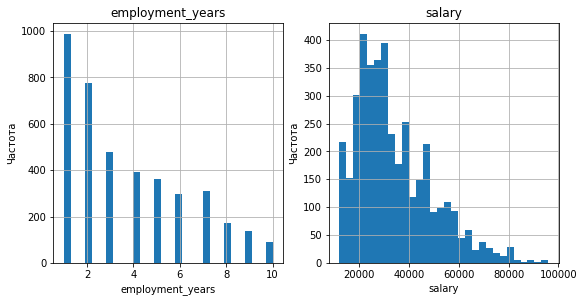

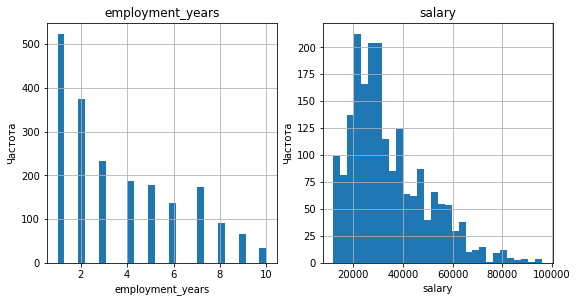

<Figure size 1008x1080 with 0 Axes>

In [42]:
#начнем с количественных переменных
# выведем графики для каждого датафрема и для его численных столбцов
df_list2 = [X_train_full2, X_test2, y_test2]
for df in df_list2:
# Выберем все столбцы, которые имеют тип данных 'float','int' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    print(num_columns)
    
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(14, 15))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(3, 3, i + 1)  # 3 строки, 3 столбца, текущий график
    
    # Строим гистограмму для текущего столбца
        df[column].hist(bins=30)
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Частота')
        
plt.tight_layout()
plt.show()

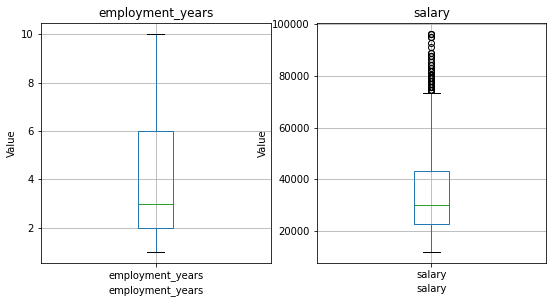

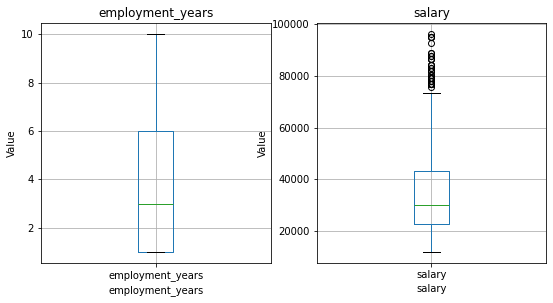

<Figure size 1008x1080 with 0 Axes>

In [43]:
for df in df_list2:
# Выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(14, 15))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(3, 3, i + 1)  # 2 строки, 3 столбца, текущий график
    
    # Строим график размаха для текущего столбца
        df.boxplot(column=column, ax=plt.gca())
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Value')
        
plt.tight_layout()
plt.show()

Пока что данные выглядят так же, как и в первой задаче. Посмотрим, что там с категориальными признаками.

Круговые диаграммы для всех категориальных переменных:



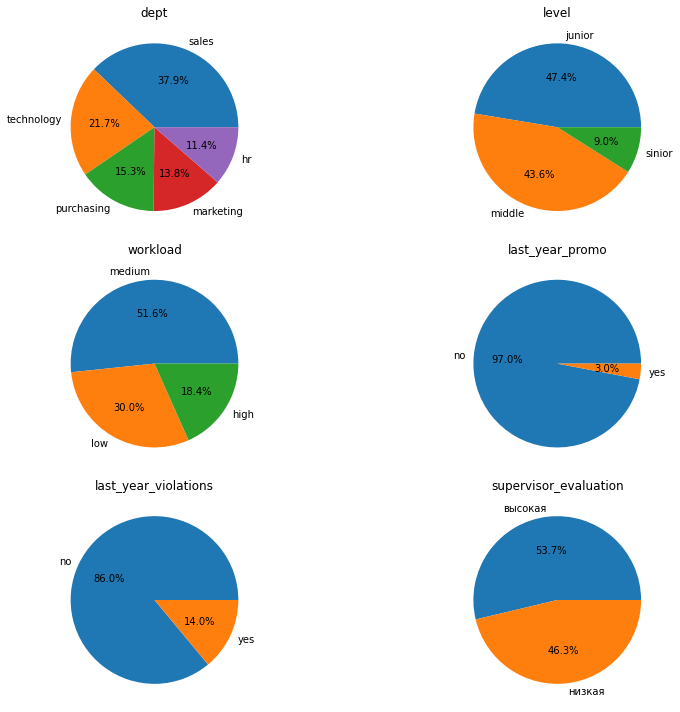

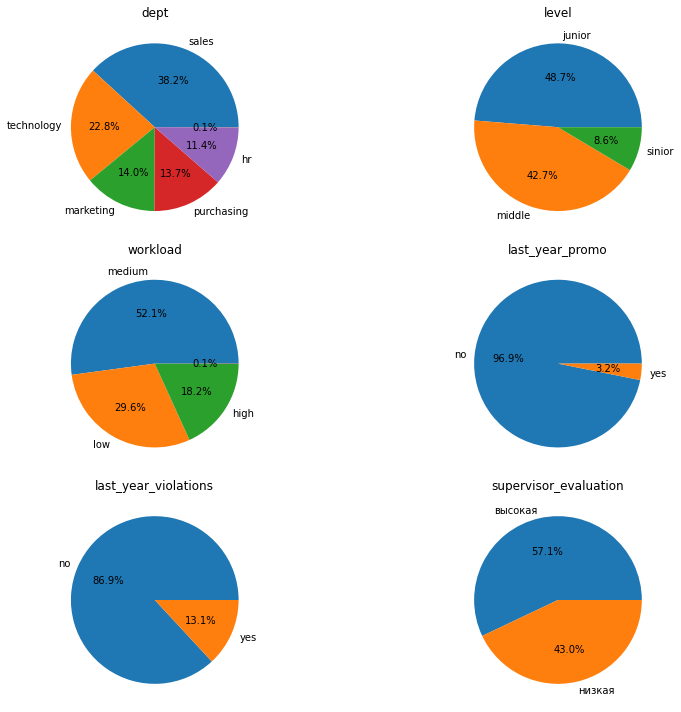

<Figure size 1008x720 with 0 Axes>

In [44]:
print('Круговые диаграммы для всех категориальных переменных:\n')

# Цикл для итерации по каждому датафрейму в списке
for df in df_list:
    plt.figure(figsize=(14, 10))
    
    # Получаем список категориальных столбцов для текущего датафрейма
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

    # Цикл для итерации по каждому категориальному столбцу
    for i, column in enumerate(categorical_columns):
        # Создаем subplot для текущего столбца
        plt.subplot(3, 2, i + 1)  # 3 строки, 2 столбца, текущий график
    
        # Подсчитываем количество каждого уникального значения в текущем столбце
        data = df[column].value_counts()
    
        # Строим круговую диаграмму для текущего столбца
        plt.pie(data, labels=data.index, autopct='%1.1f%%')
    
        # Добавляем заголовок с названием столбца
        plt.title(column)

    # Отображаем все круговые диаграммы для текущего датафрейма
    plt.tight_layout()
    plt.show()

Так же для наглядности выведем матрицу корреляции для всех признаков 

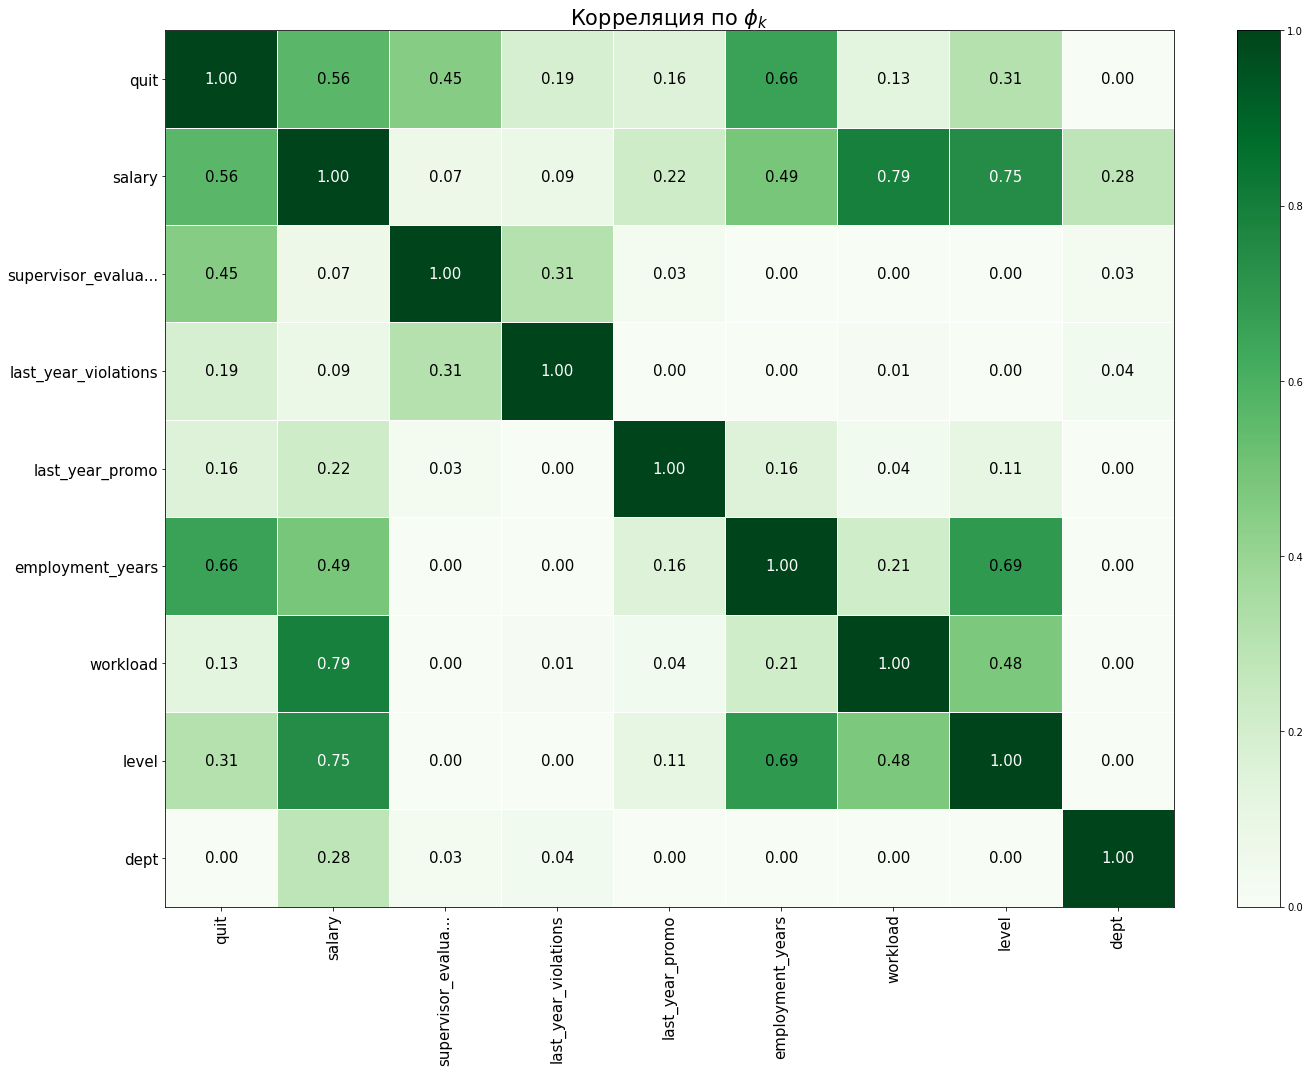

In [45]:
df_corr2 = X_train_full2.drop(columns=['id'])
#соберем все численные переменные в датафрейме с помощью функции и сохраним их в переменную
num_columns = df_corr2.select_dtypes(include=['float64','int64']).columns.tolist()

phik_matrix = df_corr2.phik_matrix(interval_cols=num_columns)

#строим матрицу корреляции Phik
plot_correlation_matrix(phik_matrix.values, 
                       x_labels = phik_matrix.columns,
                       y_labels = phik_matrix.index,
                       vmin = 0, vmax = 1,color_map = 'Greens',
                       title = r'Корреляция по $\phi_k$',
                       fontsize_factor = 1.5, 
                       figsize = (20,15)
                       )

В данной матрице особых зависимостей между входными и целевым признаком обнаружено не было, утечки признака нет. Больше всего на него влияют такие признаки как зарплата и годы стажа. <br/>
Мультиколлинеарности замечено не было.

Из значимых изменений у нас появился только столбец quit, который показывает увольнение сотрудника из компании. Это наш целевой признак в данной задаче. Слава богу тех, кто уволился намного меньше, чем тех кто нет. Но это значит что у нас имеется дисбаланс классов. <br/>
Рассмотрим поближе, тех кто уволился
#### Портрет "Уволившегося сотрудника"
Для этого создадим датафрейм где отберем только уволившихся сотрудников и тех ктоо не уволнялся, и посмотрим их распределения их признаков, чтобы сопоставить их и составить собирательный образ такого работника.

In [46]:
# создаем такой датафрейм
quit_yes = X_train_full2[X_train_full2['quit'] == 'yes']
quit_no = X_train_full2[X_train_full2['quit'] == 'no']

['id', 'employment_years', 'salary']
['id', 'employment_years', 'salary']


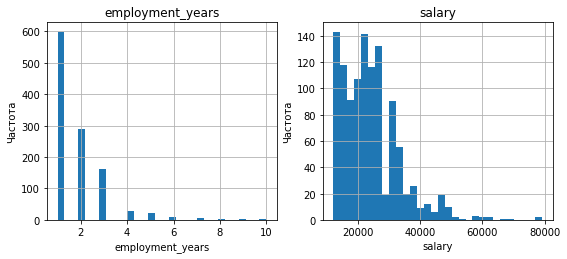

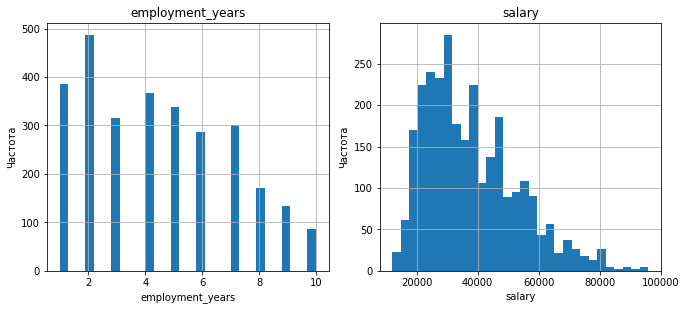

In [47]:
# выводим графики для числовых переменных
df_list3 = [quit_yes, quit_no]
for df in df_list3:
# Выберем все столбцы, которые имеют тип данных 'float','int' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    print(num_columns)
    
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(14, 8))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(2, 3, i + 1)  # 3 строки, 3 столбца, текущий график
    
    # Строим гистограмму для текущего столбца
        df[column].hist(bins=30)
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Частота')
        
plt.tight_layout()
plt.show()

И уже сразу в глаза бросаются различия:
* уволившиеся сотрудники обычно - новички в компании. Редкое исключение, если увольняется тот, кто работает долго
* оценка качества работы в среднем 3 балла, в то время как у неуволившихся - 4
* среняя зарплата уволившегося - 20 тыс. , в то время как в контр сегменте 20тыс это только начало подьема графика.

Круговые диаграммы для всех категориальных переменных:



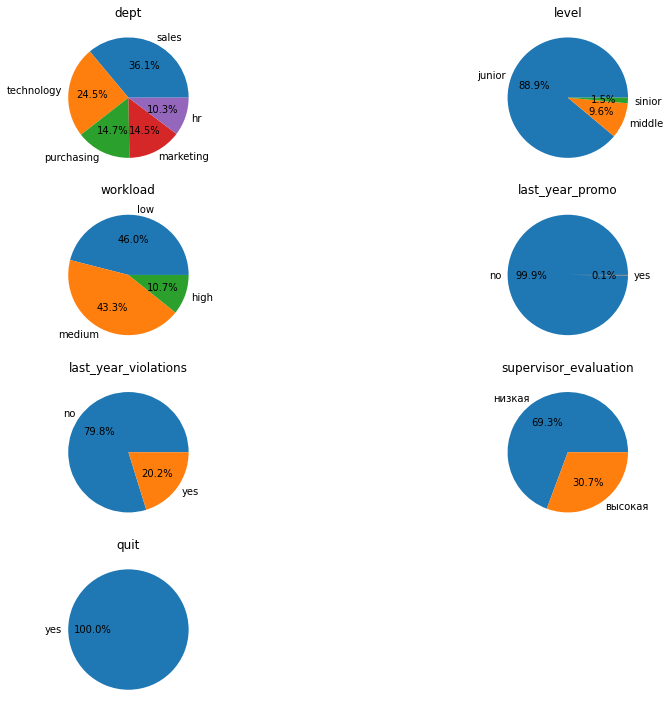

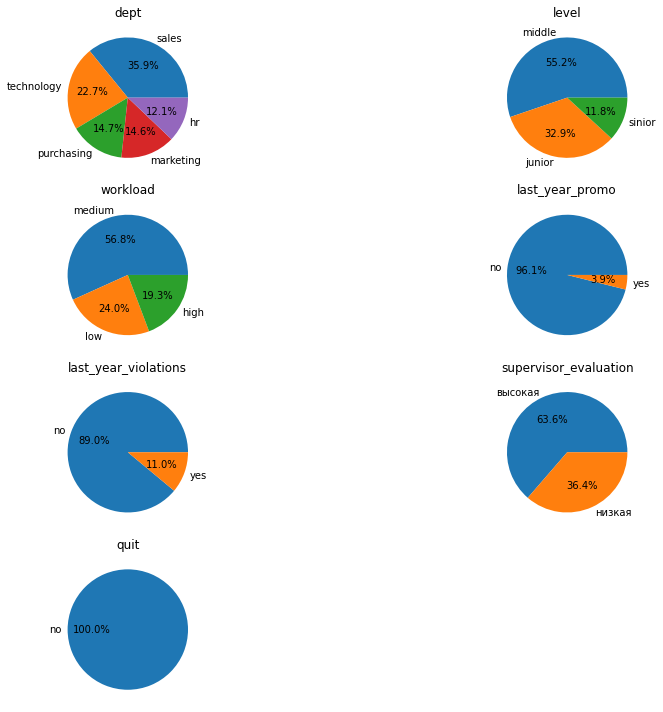

In [48]:
print('Круговые диаграммы для всех категориальных переменных:\n')

# Цикл для итерации по каждому датафрейму в списке
for df in df_list3:
    plt.figure(figsize=(14, 10))
    
    # Получаем список категориальных столбцов для текущего датафрейма
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

    # Цикл для итерации по каждому категориальному столбцу
    for i, column in enumerate(categorical_columns):
        # Создаем subplot для текущего столбца
        plt.subplot(4, 2, i + 1)  # 3 строки, 2 столбца, текущий график
    
        # Подсчитываем количество каждого уникального значения в текущем столбце
        data = df[column].value_counts()
    
        # Строим круговую диаграмму для текущего столбца
        plt.pie(data, labels=data.index, autopct='%1.1f%%')
    
        # Добавляем заголовок с названием столбца
        plt.title(column)

    # Отображаем все круговые диаграммы для текущего датафрейма
    plt.tight_layout()
    plt.show()

Сдесь различия тоже есть, но самые заметные это
* уволившиеся были менее загружены на работе
* большинство - Junior

**Если составлять портрет 'Уволившегося сотрудника', то его характеристики будут такими:**
* Работает в компании около года
* оценка работы сотрудника - 3 из 5
* средняя зарплата - 20 тыс.
* Junior в отделе продаж с низкой загруженностью по работе 

#### Проверка теории о влиянии оценки удовлетворенности сотрудника на его увольнение

In [49]:
#возьмем два датафрейма с целевыми признаками для тестовой выборки и объединим их
rate_quit = pd.merge(y_test,y_test2, on = 'id')
rate_quit.head(10)

,id,job_satisfaction_rate,quit
0,100298,0.80,no
1,100480,0.84,no
2,100503,0.79,no
3,100610,0.75,no
4,100692,0.69,no
5,100710,0.68,no
6,100894,0.49,no
7,102102,0.73,no
8,102222,0.66,no
9,102320,0.26,no


In [50]:
#теперь разделим на 2 категории: уволившиеся и нет
quit_yes2 = rate_quit[X_train_full2['quit'] == 'yes']
quit_no2 = rate_quit[X_train_full2['quit'] == 'no']

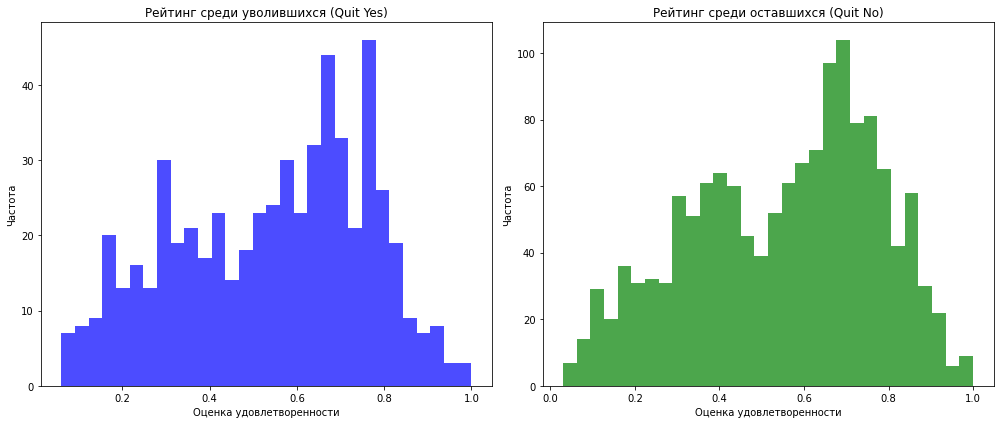

In [51]:
#выведем графики распределения уровня оценки удовлетворения для обоих категорий
plt.figure(figsize=(14, 6))

# Первая гистограмма для quit_yes2
plt.subplot(1, 2, 1)
plt.hist(quit_yes2['job_satisfaction_rate'], bins=30, color='blue', alpha=0.7)
plt.title('Рейтинг среди уволившихся (Quit Yes)')
plt.xlabel('Оценка удовлетворенности')
plt.ylabel('Частота')

# Вторая гистограмма для quit_no2
plt.subplot(1, 2, 2)
plt.hist(quit_no2['job_satisfaction_rate'], bins=30, color='green', alpha=0.7)
plt.title('Рейтинг среди оставшихся (Quit No)')
plt.xlabel('Оценка удовлетворенности')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

По графикам видно, что оценки удовлетворенности не сильно различаются, разве что на совсем немного. В целом графики похожи. Может быть мы чего то не замечаем? Расчитаем средние значения с помощью функции


In [52]:
print(quit_yes2['job_satisfaction_rate'].mean())
quit_no2['job_satisfaction_rate'].mean()

0.5413471502590673


0.5518085855031668

Удивительно, но числа слишком близки между собой. Видимо этот показатель не сильно влияет на фактическое увольнение. Может быть люди не до конца честны при ответе, либо не придают этому тесту особого значения. В любом случае, на увольнение оказывают влияние другие факторы, точно не этот.

### Шаг. Добавление нового входного признака
Добавим в исходные датафреймы df_train_full и X_test новый входной признак, а именно уровень удовлетворенности, предсказанный лучшей моделью из первой задачи

In [53]:
#введем сразу константы и разделим наш датафрейм на тестовую и тренировочную выборки
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train2 = X_train_full2.drop(
        [
            'quit'
        ], 
        axis=1
    )
y_train2 = X_train_full2['quit']

y_train_pred2 = grid_search.predict(X_train2)
y_test_pred2 = grid_search.predict(X_test2)



In [54]:
# теперь добавим получившиеся предсказания в тренировочный и тестовый датафремы с входными признаками
X_train2['job_satisfaction_rate'] = y_train_pred2
X_test2['job_satisfaction_rate'] = y_test_pred2

# проверим что все в порядке
display(X_train2.head())
X_test2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2600,100222,sales,junior,medium,3,no,no,низкая,20400,0.350465
717,100459,purchasing,junior,medium,3,no,no,низкая,21600,0.371450
2455,100469,marketing,junior,medium,1,no,no,высокая,28800,0.679756
1592,100601,technology,middle,high,4,no,no,высокая,68400,0.789885
2657,100858,sales,junior,medium,2,no,no,высокая,25200,0.696176


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1172,100298,hr,junior,low,2,no,no,высокая,19200,0.784238
852,100480,marketing,junior,low,4,no,no,высокая,16800,0.790212
848,100503,purchasing,middle,high,5,no,no,высокая,55200,0.752669
524,100610,sales,middle,medium,5,no,no,высокая,43200,0.759909
476,100692,sales,middle,high,6,no,no,высокая,48000,0.694279


Отлично, мы получили 2 датафрейма с входными признаками для тестовой и тренировочной выборки. Добавили предсказанный признак, и убедились что все в порядке. Можно начинать выбор модели для решения задачи.

### Шаг. Подготовка данных

In [55]:
# создадим списки для каждого кодирования

#для удобства выведем списки всех численных переменных, созданные ранее с помощью функции
num_columns = X_train2.select_dtypes(include=['float64','int64']).columns.tolist()
num_columns

['id', 'employment_years', 'salary', 'job_satisfaction_rate']

In [56]:
# и так же варианты значения категориальных
cat_columns = X_train2.select_dtypes(include=['object']).columns.tolist()
for column in cat_columns:
        unique_values = X_train2[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")

Уникальные значения для столбца 'dept': ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения для столбца 'level': ['junior' 'middle' 'sinior']
Уникальные значения для столбца 'workload': ['medium' 'high' 'low']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['низкая' 'высокая']


In [57]:
# признаки для OneHotEncoder
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

# признаки для OrdinalEncoder
ord_columns = ['level', 'workload', 'supervisor_evaluation']

# численные признаки
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate']

In [58]:
# cоздаём пайплайн для подготовки признаков из списка ohe_columns:
ohe_pipe = Pipeline([
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (    'ohe', 
            OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop='first')
        )
])

In [59]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns:
ord_pipe = Pipeline([
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior','middle','sinior'],
                    ['low','medium','high'],
                    ['низкая', 'высокая']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
       (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
])

In [60]:
# создайте общий пайплайн для объединения шагов подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)   
    ], 
    remainder =  'passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='m...
                                                  OrdinalEncoder(categories=[['junior',
                                   

Так как в данном пункте мы столкнулись с задачей классификации, из-за того что целевой признак грубо говоря имеет бинарный вид, мы будем пользоваться моделями для задач классификации, а не регрессии как в 1 задаче.

In [61]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

Создадим словарь для каждой модели, в котором укажем гиперпараметры для дальнейшего перебора

In [62]:
param_distributions = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__min_samples_split': range(2,20) ,
        'models__min_samples_leaf': range(2,20) ,
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability = True)],
        'models__kernel':('rbf','linear','poly'),
        'models__C': range(1,100),
        'models__degree': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__solver': ('liblinear', 'saga', 'lbfgs'),
        'models__penalty': ('l1', 'l2', 'elasticnet', 'none'),
        'models__C': range(1,100),
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }

] 

### Шаг. Обучение моделей
Теперь приступим к обучению наших моделей и автоматизированному подбору лучшей с помощью RandomizedSearchCV

In [63]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [64]:
le = LabelEncoder()
y_train2 = le.fit_transform(y_train2)
y_train2

array([1, 1, 0, ..., 1, 0, 0])

In [65]:
#обучим модель на тренировочной выборке
randomized_search.fit(X_train2, y_train2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                                            'poly'),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 100),
                                         'models__penalty': ('l1', 'l2',
                                                             'elasticnet',
                                                             'none'),
                                         'models__solver': ('liblinear', 'saga',
                                                            'lbfgs'),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [66]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика ROC_AUC лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [67]:
X_test2 = X_test2.sort_values(by = 'id')
y_test2 = y_test2.sort_values(by = 'id')

Теперь рассчитаем метрику для тестовой выборки

In [68]:
y_test2 = y_test2['quit']

In [69]:
y_test2 = le.transform(y_test2)
y_test2

array([0, 0, 0, ..., 1, 0, 1])

In [70]:
y_test_probas2 = randomized_search.predict_proba(X_test2)[:,1]
y_test_probas2

array([0.03892944, 0.03892944, 0.01102941, ..., 0.67871486, 0.        ,
       0.93693694])

In [71]:
print(y_test2.shape)
y_test_probas2.shape

(2000,)


(2000,)

In [72]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test2, y_test_probas2)}')

Метрика ROC-AUC на тестовой выборке: 0.9222833817341314


### Вывод по 2 задаче:

Мы достигли желаемого значения метрики ROC_AUC путем перебора всех моделей и всех гиперпараметров с помощью рандомного перебора RandomizedSearchCV. Лушая модель получилась - DecisionTreeClassifier(max_depth=6, max_features=14,min_samples_leaf=15, min_samples_split=14,random_state=42).Значение метрики на тренировочной выборке было получено - 0.926, а на тестовой - 0.922


## Общий вывод

Перед нами стояло 2 задачи: решить проблему предсказания оценки удовлетворенности сотрудника, и вторая - предсказать возможное увольнение сотрудника из компании. Обе эти задачи решаются с помощью моделей машинного обучение, а именно первая задача решается с помощью моделей регрессии, а вторая - модели для классификации. <br/><br/>
**Этапы работы** <br/>

В обоих задачах мы действовали примерно по одному плану:
* просмотр датасетов с данными
* обработка данных, устранение возможных проблем с данными. Проверка на пропуски и дубликаты
* исследовательский анализ данных
* подготовка данных для дальнейшего использования при обучении моделей(масштабирование численных значений и кодирование категориальных)
* написание пайплайна для обработки данных и подбора гиперпараметра моделей
* само обучение модели на тренировочных данных
* проверка метрик и доведение работы модели до лучшего результата
* предсказание на тестовой выборке и оценка полученных значений с помощью метрик
* написание выводов о проделанной работе

**Выводы и предложения для бизнеса** <br/><br/>
Вручную перебирать и проверять показатели метрик каждой модели и их результаты со всеми вариациями гиперпараметров было бы невероятно долго, поэтому в данной работе мы реализовали подбор с помощью пайплайна, а так же включили в него предобработку данных, кодирование, масштабирование и заполнение пропусков. Это решение сокращает время поиска лучшей модели и позволяет решать задачи для бизнеса быстрее. <br/><br/>
Если говорить об удовлетворенности сотрудников, то скорее всего этот показатель в тесте не сильно влияет на действительное увольнение сотрудника, потому что в тесте можно ответить что угодно. Достаточно больше о возможном увольнении говорит уровень зарплаты работника и стаж его работы. Больший процент уволившихся будет состоять из стажеров которые только устроились, и у них маленький уровень зарплаты. Чем выше зарпалата и чем дольше человек работает в организации - тем ниже шанс что он решит уволиться.

